<center>
<img src="../../img/ods_stickers.jpg">
## Открытый курс по машинному обучению. Сессия № 2
</center>
Автор материала: Юрий Исаков и Юрий Кашницкий. Материал распространяется на условиях лицензии [Creative Commons CC BY-NC-SA 4.0](https://creativecommons.org/licenses/by-nc-sa/4.0/). Можно использовать в любых целях (редактировать, поправлять и брать за основу), кроме коммерческих, но с обязательным упоминанием автора материала.

# <center>Тема 4. Линейные модели классификации и регрессии
## <center>  Практика. Идентификация пользователя с помощью логистической регрессии

Тут мы воспроизведем парочку бенчмарков нашего соревнования и вдохновимся побить третий бенчмарк, а также остальных участников. Веб-формы для отправки ответов тут не будет, ориентир – [leaderboard](https://www.kaggle.com/c/catch-me-if-you-can-intruder-detection-through-webpage-session-tracking2/leaderboard) соревнования.

In [7]:
import pickle
import numpy as np
import pandas as pd
from tqdm import tqdm_notebook
from scipy.sparse import csr_matrix, hstack
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import roc_auc_score
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import SGDClassifier

%matplotlib inline
from matplotlib import pyplot as plt
import seaborn as sns
import datetime 
from xgboost import XGBClassifier
from collections import Counter
import seaborn as sns
import matplotlib.pyplot as plt
import time
import datetime as dt
import os

### 1. Загрузка и преобразование данных
Зарегистрируйтесь на [Kaggle](www.kaggle.com), если вы не сделали этого раньше, зайдите на [страницу](https://inclass.kaggle.com/c/catch-me-if-you-can-intruder-detection-through-webpage-session-tracking2) соревнования и скачайте данные. Первым делом загрузим обучающую и тестовую выборки и посмотрим на данные.

In [8]:
# загрузим обучающую и тестовую выборки
train_df = pd.read_csv('../../data/train_sessions.csv',
                       index_col='session_id')
test_df = pd.read_csv('../../data/test_sessions.csv',
                      index_col='session_id')

# приведем колонки time1, ..., time10 к временному формату
times = ['time%s' % i for i in range(1, 11)]
train_df[times] = train_df[times].apply(pd.to_datetime)
test_df[times] = test_df[times].apply(pd.to_datetime)

train_df = train_df[(train_df['time1'] > datetime.date(year=2013,month=11,day=1))]
#--------------------------------------
#filtering


start = dt.datetime.strptime('2014-01-01 00:00:00', '%Y-%m-%d %H:%M:%S')
end = dt.datetime.strptime('2013-01-13 01:00:00', '%Y-%m-%d %H:%M:%S')
train_df = train_df[(train_df['time1'] <= start) | (train_df['time1'] >= end)]

# start = dt.datetime.strptime('2013-12-01 00:00:00', '%Y-%m-%d %H:%M:%S')
# end = dt.datetime.strptime('2013-12-19 01:00:00', '%Y-%m-%d %H:%M:%S')
# df1 = train_df[(train_df['time1'] > start) & (train_df['time1'] < end)]

# start = dt.datetime.strptime('2013-12-19 00:00:00', '%Y-%m-%d %H:%M:%S')
# end = dt.datetime.strptime('2014-03-05 01:00:00', '%Y-%m-%d %H:%M:%S')
# df2 = train_df[(train_df['time1'] > start) & (train_df['time1'] < end)]

# start = dt.datetime.strptime('2014-03-18 00:00:00', '%Y-%m-%d %H:%M:%S')
# df3 = train_df[(train_df['time1'] > start) ]


# train_df = pd.concat([df1,df2,df3])
#-------------------------------------

df = pd.concat([train_df.target, train_df.time1.dt.weekday.rename('weekday'), train_df.time1.dt.hour.rename('hour')], axis=1)
piv = pd.pivot_table(df, values="target",index=["hour"], columns=["weekday"], fill_value=0, aggfunc=np.sum)
sns.heatmap(piv)


df = pd.concat([train_df.target, ((train_df.time1.dt.year-2013)*365+train_df.time1.dt.dayofyear).rename('dayofyear'), train_df.time1.dt.hour.rename('hour')], axis=1)
piv = pd.pivot_table(df, values="target",index=["hour"], columns=["dayofyear"], fill_value=0, aggfunc=np.sum)
sns.heatmap(piv)

# отсортируем данные по времени
train_df = train_df.sort_values(by='time1')

# посмотрим на заголовок обучающей выборки
#train_df.head()

In [9]:
#train_df['time1'].dt.date.to_csv('train_dates')

#fig, ax = plt.subplots(figsize=(20,10)) 

#train_df.groupby(train_df['time1'].dt.date).to_csv('train_dates')

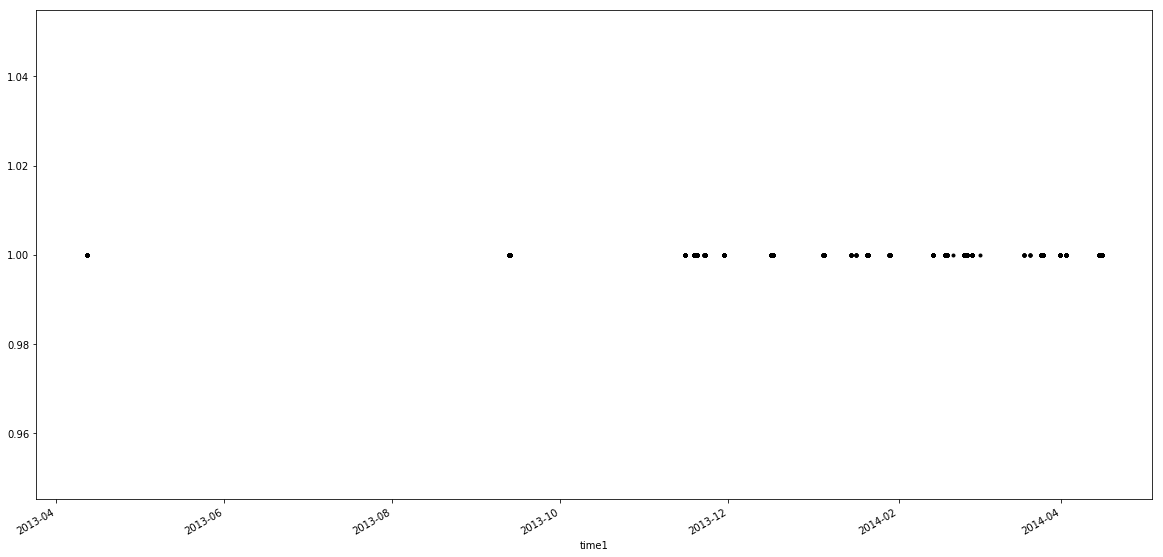

In [10]:

PATH_TO_DATA = ('../../data')


start = dt.datetime.strptime('2013-02-28 00:00:00', '%Y-%m-%d %H:%M:%S')
end = dt.datetime.strptime('2014-04-28 01:00:00', '%Y-%m-%d %H:%M:%S')



fig, ax = plt.subplots(figsize=(20,10)) 

train_for_check = pd.read_csv(os.path.join(PATH_TO_DATA, 'train_sessions.csv'), index_col='time1', parse_dates=['time1'])
train_for_check = train_for_check[train_for_check['target'] == 1]
y_may = train_for_check[str(start):str(end)]['target']

#print(train_df[train_df['target'] == 1].shape)
times = ['time%s' % i for i in range(1, 11)]

y_may.plot(style='k.', ax=ax)

В обучающей выборке содержатся следующие признаки:
    - site1 – индекс первого посещенного сайта в сессии
    - time1 – время посещения первого сайта в сессии
    - ...
    - site10 – индекс 10-го посещенного сайта в сессии
    - time10 – время посещения 10-го сайта в сессии
    - target – целевая переменная, 1 для сессий Элис, 0 для сессий других пользователей
    
Сессии пользователей выделены таким образом, что они не могут быть длиннее получаса или 10 сайтов. То есть сессия считается оконченной либо когда пользователь посетил 10 сайтов подряд либо когда сессия заняла по времени более 30 минут.

В таблице встречаются пропущенные значения, это значит, что сессия состоит менее, чем из 10 сайтов. Заменим пропущенные значения нулями и приведем признаки к целому типу. Также загрузим словарь сайтов и посмотрим, как он выглядит:

In [11]:
# приведем колонки site1, ..., site10 к целочисленному формату и заменим пропуски нулями
sites = ['site%s' % i for i in range(1, 11)]
train_df[sites] = train_df[sites].fillna(0).astype('int')
test_df[sites] = test_df[sites].fillna(0).astype('int')

# загрузим словарик сайтов
with open(r"../../data/site_dic.pkl", "rb") as input_file:
    site_dict = pickle.load(input_file)

# датафрейм словарика сайтов
sites_dict_df = pd.DataFrame(list(site_dict.keys()), 
                          index=list(site_dict.values()), 
                          columns=['site'])
print(u'всего сайтов:', sites_dict_df.shape[0])
sites_dict_df.head()

всего сайтов: 48371


,site
37013,www.revue-texto.net
14126,i1-js-14-3-01-11074-548663891-i.init.cedexis-r...
20884,us18.zopim.com
34299,i1-js-14-3-01-10005-444737283-i.init.cedexis-r...
22549,imagescms.lelynx.fr


Выделим целевую переменную и объединим выборки, чтобы вместе привести их к разреженному формату.

In [291]:
# наша целевая переменная
y_train = train_df['target']

# объединенная таблица исходных данных
full_df = pd.concat([train_df.drop('target', axis=1), test_df])


# new_features = [
#                 '07_08',
#                 '12_13',
#                'is_sunday',
#                 '16_18',
#                 '19_23',
#     'is_monday',
#                'is_tuesday',
#                 'yyyymm',
#                ]
#0.9840773
#0.94898

# new_features = [
#                 '07_08',
#                 '12_13',
#                 '16_18',
#                 'is_sunday',
#                 'is_monday',
#                'is_tuesday',
#                 'yyyymm',
#     'duration'
#                ]
#
#0.951 kag
#0.9854357311817761
#0.969 074854553


# new_features = [
#                 '07_08',
#                 '12_13',
#                 '16_18',
#                 'is_sunday',
#                 'is_monday',
#                'is_tuesday',
#                     'is_saturday',
#                 'yyyymm',
#     'duration',
#                ]
#0.95101
#0.969 3055832962


#---------------------
# new_features = [
#                 '07_08',
#                 '12_13',
#                 '16_18',
#                 'is_sunday',
#                 'is_monday',
#                'is_tuesday',
#                 'yyyymm',
#                 'duration',
#     'day_12',12
#     'day_14',12
#     'day_17',12
#     'day_24',12
#     'day_29'12
#                ]
#-0.00088
#0.9698442695475425
#0.95126

# new_features = [
#                 '07_08',
#                 '12_13',
#                 '16_18',
#                 'is_sunday',
#                 'is_monday',
#                'is_tuesday',
#                 'yyyymm',
#                 'duration',
#     'day_12', 'day_24',
    
#                ]

#0.950
#0.9712656951593279


# new_features = [
#                 '07_08',
#                 '12_13',
#                 '16_18',
#                 'is_sunday',
#                 'is_monday',
#                'is_tuesday',
#                 'yyyymm',
#                 'duration',
#     'day_12'
    
#                ]
#auc 0.9698266797074342
#0.95127


# new_features = [
#                 '07_08',
#                 '12_13',
#                 '16_18',
#                 'is_sunday',
#                 'is_monday',
#                'is_tuesday',
#     'is_thursday',
#                 'yyyymm',
#                 'duration',
#     'day_12',
#                ]
#0.9511814

# new_features = [
#                 '07_08',
#                 '12_13',
#                 '16_18',
#                 'is_sunday',
#                 'is_monday',
#                'is_tuesday',
#                 'yyyymm',
#                 'duration',
#     'day_12',
#     '19_23'
#                ]
#
#
#0.95134 kagle
#0.96982466051

# new_features = [
#                 '07_08',  
#                 '10_11',
#                 '12_13',
#                 '16_18',
#                 'is_sunday',
#                 'is_monday',
#                'is_tuesday',
#                 'yyyymm',
#                 'duration',
#     'day_12',
#     '19_23'
#                ]

new_features = [
                '07_08',
                '12_13',
                '16_18',
                'is_sunday',
                'is_monday',
               'is_tuesday',
                'yyyymm',
                'duration',
    'day_12',
    '19_23',
    'session1',
    
               ]
#0.95178

new_features = [
                '07_08',
                '12_13',
                '16_18',
                'is_sunday',
                'is_monday',
               'is_tuesday',
                'yyyymm',
                'duration',
    'day_12',
     '19_23',
               ]

#0.95172

new_features = [
                'morning',
                '12_13',
                '16_18',
                'is_sunday',
                'is_monday',
               'is_tuesday',
                'yyyymm',
                'duration',
    'day_12',
     '19_23',
               ]


full_df['start_session_day'] = full_df['time1'].dt.day
full_df['month'] = full_df['time1'].dt.month
full_df['month_9'] = (full_df['time1'].dt.month == 9).astype(int)

full_df['month_quad'] = ((full_df['month'] >= 5) & (full_df['month'] <= 8)).astype(int)


full_df['duration'] = (full_df[times].max(axis=1) - full_df['time1']).dt.seconds
full_df['duration_alice'] = ((full_df['duration'] > 35) & (full_df['duration'] <= 40)).astype(int)

full_df["morning"] = ((full_df['time1'].dt.hour <= 11)).astype(int)

full_df["07_09"] = ((full_df['time1'].dt.hour >= 7) & (full_df['time1'].dt.hour <= 9)).astype(int)

full_df["07_08"] = ((full_df['time1'].dt.hour >= 7) & (full_df['time1'].dt.hour <= 8)).astype(int)
full_df["10_11"] = ((full_df['time1'].dt.hour >= 10) & (full_df['time1'].dt.hour <= 11)).astype(int)

full_df["08_09"] = ((full_df['time1'].dt.hour >= 8) & (full_df['time1'].dt.hour <= 9)).astype(int)

full_df["12_13"] = ((full_df['time1'].dt.hour >= 12) & (full_df['time1'].dt.hour <= 13)).astype(int)
full_df["16_18"] = ((full_df['time1'].dt.hour >= 16) & (full_df['time1'].dt.hour <= 18)).astype(int)
full_df["19_23"] = ((full_df['time1'].dt.hour >= 19) & (full_df['time1'].dt.hour <= 23)).astype(int)

full_df["19_08"] = ((full_df['time1'].dt.hour < 8) | (full_df['time1'].dt.hour >= 19)).astype(int)

start = dt.datetime.strptime('2013-12-26 00:00:00', '%Y-%m-%d %H:%M:%S')
end = dt.datetime.strptime('2014-01-20 01:00:00', '%Y-%m-%d %H:%M:%S')
full_df["session1"] = ((full_df['time1'] >= start) & (full_df['time1'] <= end)).astype(int)

starth = dt.datetime.strptime('2014-01-22 00:00:00', '%Y-%m-%d %H:%M:%S')
endh = dt.datetime.strptime('2014-02-01 01:00:00', '%Y-%m-%d %H:%M:%S')
full_df["holidays1"] = ((full_df['time1'] >= starth) & (full_df['time1'] <= endh)).astype(int)

start2 = dt.datetime.strptime('2014-06-04 00:00:00', '%Y-%m-%d %H:%M:%S')
end2 = dt.datetime.strptime('2014-06-30 01:00:00', '%Y-%m-%d %H:%M:%S')
full_df["session2"] = ( (full_df['time1'] >= start2) & (full_df['time1'] <= end2)).astype(int)

start2h = dt.datetime.strptime('2014-07-01 00:00:00', '%Y-%m-%d %H:%M:%S')
end2h = dt.datetime.strptime('2014-09-30 01:00:00', '%Y-%m-%d %H:%M:%S')
full_df["holidays2"] = ((full_df['time1'] >= start2h) & (full_df['time1'] <= end2h)).astype(int)

# import pandas.tseries.holiday as hol
# us_cal = hol.USFederalHolidayCalendar()
# dr = pd.date_range(start='2013-07-01', end='2015-08-01')
# us_holidays = us_cal.holidays(start=dr.min(), end=dr.max())
# full_df['Holiday'] = full_df['time1'].isin(us_holidays)



full_df['yyyymm'] = full_df['time1'].dt.strftime('%Y%m').astype(int)

full_df["is_monday"] = full_df['time1'].dt.weekday.isin([0])*1 #индикатор выходных
full_df["is_tuesday"] = full_df['time1'].dt.weekday.isin([1])*1 #индикатор выходных
full_df["is_wednesday"] = full_df['time1'].dt.weekday.isin([2])*1 #индикатор выходных
full_df["is_thursday"] = full_df['time1'].dt.weekday.isin([3])*1 #индикатор выходных
full_df["is_friday"] = full_df['time1'].dt.weekday.isin([4])*1 #индикатор выходных

full_df["is_saturday"] = full_df['time1'].dt.weekday.isin([5])*1 #индикатор выходных
full_df["is_sunday"] = full_df['time1'].dt.weekday.isin([6])*1 #индикатор выходных

full_df['day_12'] = (full_df['time1'].dt.day == 12).astype(int)
full_df['day_13'] = (full_df['time1'].dt.day == 13).astype(int)
full_df['day_14'] = (full_df['time1'].dt.day == 14).astype(int)
full_df['day_15'] = (full_df['time1'].dt.day == 15).astype(int)
full_df['day_16'] = (full_df['time1'].dt.day == 16).astype(int)
full_df['day_17'] = (full_df['time1'].dt.day == 17).astype(int)
full_df['day_19'] = (full_df['time1'].dt.day == 19).astype(int)
full_df['day_22'] = (full_df['time1'].dt.day == 22).astype(int)
full_df['day_24'] = (full_df['time1'].dt.day == 24).astype(int)
full_df['day_25'] = (full_df['time1'].dt.day == 25).astype(int)
full_df['day_29'] = (full_df['time1'].dt.day == 29).astype(int)
full_df['week_period'] = full_df['time1'].dt.day//7


alice_words = train_df[(train_df['target'] == 1)][sites]
alice_words['alice_text'] = alice_words[sites].astype(str).apply(lambda x: ' '.join(x), axis=1)
alice_words_list = [word for word in alice_words['alice_text'].apply(lambda x: x.split(' '))]
alice_flatten = list(np.array(alice_words_list).flat)
alice_most_freq_sites = Counter(alice_flatten)#.most_common(100)
alice_top_sites  = sorted(alice_most_freq_sites, key=alice_most_freq_sites.get, reverse=True)[:10]
full_df['alice_top_words'] = (full_df[sites].astype(str).isin(alice_top_sites)==True).sum(axis=1)



#full_df["is_thur_fri_lunch"] = ((full_df['time1'].dt.weekday.isin([3,4])*1) & ((full_df['time1'].dt.hour >= 12) & (full_df['time1'].dt.hour <= 13)).astype(int)) #индикатор выходных
#full_df["is_mon_tue_diner"] = ((full_df['time1'].dt.weekday.isin([0,1])*1) & ((full_df['time1'].dt.hour >= 16) & (full_df['time1'].dt.hour <= 18)).astype(int)) #индикатор выходных


# индекс, по которому будем отделять обучающую выборку от тестовой
idx_split = train_df.shape[0]

Для самой первой модели будем использовать только посещенные сайты в сессии (но не будем обращать внимание на временные признаки). За таким выбором данных для модели стоит такая идея:  *у Элис есть свои излюбленные сайты, и чем чаще вы видим эти сайты в сессии, тем выше вероятность, что это сессия Элис и наоборот.*

Подготовим данные, из всей таблицы выберем только признаки `site1, site2, ... , site10`. Напомним, что пропущенные значения заменены нулем. Вот как выглядят первые строки таблицы:

In [292]:
# табличка с индексами посещенных сайтов в сессии
full_sites = full_df[sites]
full_sites.head()

,site1,site2,site3,site4,site5,site6,site7,site8,site9,site10
session_id,,,,,,,,,,
168447,6725,41475,41476,41475,41475,6725,41475,41476,41476,6725
141689,22,707,56,55,55,23,21,222,57,21
6214,784,73,0,0,0,0,0,0,0,0
35728,820,820,167,167,359,167,167,3,167,384
243069,48,45,23,52,23,176,343,175,23,178


Сессии представляют собой последовательность индексов сайтов и данные в таком виде неудобны для линейных методов. В соответствии с нашей гипотезой (у Элис есть излюбленные сайты) надо преобразовать эту таблицу таким образом, чтобы каждому возможному сайту соответствовал свой отдельный признак (колонка), а его значение равнялось бы количеству посещений этого сайта в сессии. Это делается в две строчки:

In [293]:
from scipy.sparse import csr_matrix

In [294]:
#csr_matrix?

(3127280,)


/usr/local/lib/python3.5/dist-packages/sklearn/feature_extraction/text.py:1089: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  if hasattr(X, 'dtype') and np.issubdtype(X.dtype, np.float):


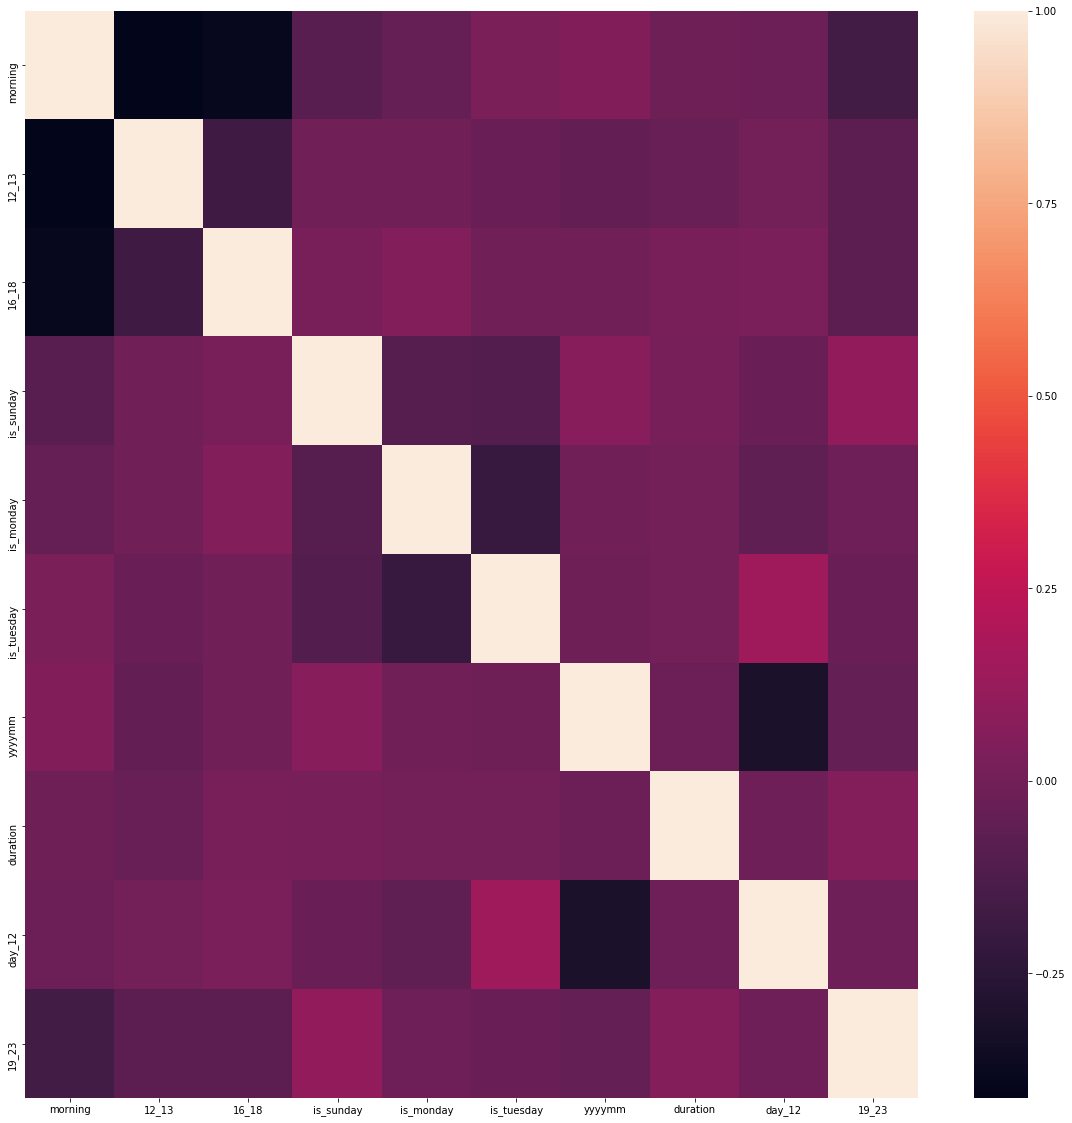

TypeError: hstack() got multiple values for argument 'format'

In [305]:
# последовательность с индексами
sites_flatten = full_sites.values.flatten()



print(sites_flatten.shape)

# искомая матрица
full_sites_sparse = csr_matrix(([1] * sites_flatten.shape[0],
                                sites_flatten,
                                range(0, sites_flatten.shape[0] + 10, 10)))[:, 1:]


#-------------------------------------------------
# from sklearn.feature_extraction.text import TfidfVectorizer
# vectorizer = TfidfVectorizer(ngram_range=(3,8), max_features=100000, max_df=0.5)
# vectorizer.fit(site_dict.keys())
# full_df['text'] = full_df[sites].astype(str).apply(lambda x: ' '.join(x), axis=1)
# #full_df['text'] = full_df['text'].apply(lambda x: x.replace('0', ''))
# tfidf_data = vectorizer.transform(full_df['text'].values)

#-------------------------------------------------

additional_df = full_df[new_features]

#additional_df = pd.get_dummies(full_df[new_features], columns=['duration'])


fig, ax = plt.subplots(figsize=(20,20)) 
sns.heatmap(additional_df.corr(), ax=ax);
plt.show()



scaler = StandardScaler()
additional_df = scaler.fit_transform(additional_df)

full_sites_sparse = hstack((csr_matrix(additional_df), full_sites_sparse), format='csr')
#full_sites_sparse = hstack(csr_matrix(additional_df), tfidf_data,  format='csr')
#full_sites_sparse = csr_matrix(additional_df)

Еще один плюс использования разреженных матриц в том, что для них имеются специальные реализации как матричных операций, так и алгоритмов машинного обучения, что подчас позволяет ощутимо ускорить операции за счет особенностей структуры данных. Это касается и логистической регрессии. Вот теперь у нас все готово для построения нашей первой модели.

### 2. Построение первой модели

Итак, у нас есть алгоритм и данные для него, построим нашу первую модель, воспользовавшись релизацией [логистической регрессии](http://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html) из пакета `sklearn` с параметрами по умолчанию. Первые 90% данных будем использовать для обучения (обучающая выборка отсортирована по времени), а оставшиеся 10% для проверки качества (validation). 

**Напишите простую функцию, которая будет возвращать качество модели на отложенной выборке, и обучите наш первый классификатор**.

In [296]:
def get_auc_lr_valid(X, y, C=1.0, ratio = 0.7, seed=17):
    '''
    X, y – выборка
    ratio – в каком отношении поделить выборку
    C, seed – коэф-т регуляризации и random_state 
              логистической регрессии
    '''
    # Split the data into the training and validation sets
    idx = int(round(X.shape[0] * ratio))
    # Classifier training
    lr = LogisticRegression(C=C, random_state=seed, n_jobs=-1).fit(X[:idx, :], y[:idx])
    # Prediction for validation set
    y_pred = lr.predict_proba(X[idx:, :])[:, 1]
    # Calculate the quality
    score = roc_auc_score(y[idx:], y_pred)
    
    return score


def auc_sgd(X, y, a=0.0001, ratio = 0.7, seed=17):
    # Split the data into the training and validation sets
    idx = int(round(X.shape[0] * ratio))
    # Classifier training
    #sgd = XGBClassifier().fit(X[:idx, :], y[:idx])
    sgd = SGDClassifier(loss='log', random_state=17, alpha=a).fit(X[:idx, :], y[:idx])
    # Prediction for validation set
    y_pred = sgd.predict_proba(X[idx:, :])[:, 1]
    # Calculate the quality
    score = roc_auc_score(y[idx:], y_pred)
    
    return score

**Посмотрите, какой получился ROC AUC на отложенной выборке.**

In [297]:
%%time
# Select the training set from the united dataframe (where we have the answers)
X_train = full_sites_sparse[:idx_split, :]

# Calculate metric on the validation set
print(get_auc_lr_valid(X_train, y_train))
print(auc_sgd(X_train, y_train))

/usr/local/lib/python3.5/dist-packages/sklearn/linear_model/logistic.py:1228: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = -1.
  " = {}.".format(self.n_jobs))


0.9686476160293721


/usr/local/lib/python3.5/dist-packages/sklearn/linear_model/stochastic_gradient.py:84: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.stochastic_gradient.SGDClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)


0.9721209851871301
CPU times: user 3.19 s, sys: 4 ms, total: 3.2 s
Wall time: 3.19 s


Будем считать эту модель нашей первой отправной точкой (baseline). Для построения модели для прогноза на тестовой выборке **необходимо обучить модель заново уже на всей обучающей выборке** (пока наша модель обучалась лишь на части данных), что повысит ее обобщающую способность:

In [298]:
# функция для записи прогнозов в файл
def write_to_submission_file(predicted_labels, out_file,
                             target='target', index_label="session_id"):
    predicted_df = pd.DataFrame(predicted_labels,
                                index = np.arange(1, predicted_labels.shape[0] + 1),
                                columns=[target])
    predicted_df.to_csv(out_file, index_label=index_label)

**Обучите модель на всей выборке, сделайте прогноз для тестовой выборки и сделайте посылку в соревновании**.

In [299]:
# Ваш код здесь
# Train the model on the whole training data set
# Use random_state=17 for repeatability
# Parameter C=1 by default, but here we set it explicitly
lr = LogisticRegression(C=1.0, random_state=17).fit(X_train, y_train)

# Make a prediction for test data set
X_test = full_sites_sparse[idx_split:,:]
y_test = lr.predict_proba(X_test)[:, 1]

# Write it to the file which could be submitted
write_to_submission_file(y_test, 'baseline_new.csv')

Если вы выполните эти действия и загрузите ответ на [странице](https://inclass.kaggle.com/c/catch-me-if-you-can-intruder-detection-through-webpage-session-tracking2) соревнования, то воспроизведете первый бенчмарк "Logit".

### 3. Улучшение модели, построение новых признаков

Создайте такой признак, который будет представлять собой число вида ГГГГММ от той даты, когда проходила сессия, например 201407 -- 2014 год и 7 месяц. Таким образом, мы будем учитывать помесячный [линейный тренд](http://people.duke.edu/~rnau/411trend.htm) за весь период предоставленных данных.

In [300]:
%%time
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV

from sklearn.model_selection import TimeSeriesSplit
from sklearn.model_selection import GridSearchCV, StratifiedKFold

max_c = -1
max_auc = 0
c_list = [0.1668100537200059]
c_list = [0.00001, 0.00009, 0.00012, 0.001, 0.011,0.11,0.12,0.13,0.14,0.15,0.1668100537200059, 1,10]
#c_list = [200,500,1000
tscv = TimeSeriesSplit(n_splits=5)

#c_list = np.logspace(-3, 1, 10)
#np.logspace(-3, 1, 10)
for c in c_list:
    print("C=",c)
    auc = get_auc_lr_valid(X_train, y_train, C=c)
    #auc = auc_sgd(X_train, y_train, a=c)
    print("auc",auc)
    if auc > max_auc:
        max_auc = auc
        max_c = c
        
print('----'*20)
print("BETTER_C=",max_c)
print("BETTER_AUC=",max_auc)


searchCV = LogisticRegressionCV(
                Cs=c_list
                ,scoring='roc_auc'
                ,cv=tscv
                ,random_state=17)
searchCV.fit(X_train, y_train)
max_auc = searchCV.scores_[1].max()
print ('Max auc_roc:', max_auc)
            


C= 1e-05


/usr/local/lib/python3.5/dist-packages/sklearn/linear_model/logistic.py:1228: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = -1.
  " = {}.".format(self.n_jobs))


auc 0.5966479818312768
C= 9e-05
auc 0.6445601927455751
C= 0.00012
auc 0.6595708191223367
C= 0.001
auc 0.8616082893745924
C= 0.011
auc 0.9610405589183388
C= 0.11
auc 0.970265509811119
C= 0.12
auc 0.9702556694027356
C= 0.13
auc 0.9702416779013086
C= 0.14
auc 0.9702111452423207
C= 0.15
auc 0.9701862808271337
C= 0.1668100537200059
auc 0.9701444116805437
C= 1
auc 0.9686476160293721
C= 10
auc 0.9670254657968897
--------------------------------------------------------------------------------
BETTER_C= 0.11
BETTER_AUC= 0.970265509811119
Max auc_roc: 0.9816584772612003
CPU times: user 1min 37s, sys: 35.6 s, total: 2min 12s
Wall time: 1min 28s


Добавьте новый признак, предварительно отмасштабировав его с помощью `StandardScaler`, и снова посчитайте ROC AUC на отложенной выборке.

In [302]:
# Ваш код здесь
lr = LogisticRegression(C=0.11, random_state=17).fit(X_train, y_train)
#sgd = XGBClassifier(0.00012).fit(X_train, y_train)
sgd = SGDClassifier(loss='log', random_state=17, alpha=0.00012).fit(X_train, y_train)

# Make a prediction for test data set
X_test = full_sites_sparse[idx_split:,:]
#y_test = lr.predict_proba(X_test)[:, 1]
#y_test = sgd.predict_proba(X_test)[:, 1]
y_test = searchCV.predict_proba(X_test)[:, 1]

# Write it to the file which could be submitted
write_to_submission_file(y_test, 'baseline_best_scv.csv')

/usr/local/lib/python3.5/dist-packages/sklearn/linear_model/stochastic_gradient.py:84: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.stochastic_gradient.SGDClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)


**Добавьте два новых признака: start_hour и morning.**

Признак `start_hour` – это час в который началась сессия (от 0 до 23), а бинарный признак `morning` равен 1, если сессия началась утром и 0, если сессия началась позже (будем считать, что утро это если `start_hour равен` 11 или меньше).

**Посчитйте ROC AUC на отложенной выборке для выборки с:**
- сайтами, `start_month` и `start_hour`
- сайтами, `start_month` и `morning`
- сайтами, `start_month`, `start_hour` и `morning`

In [222]:
# Ваш код здесь


PATH_TO_DATA = ('')
stack1 = pd.read_csv(os.path.join(PATH_TO_DATA, 'baseline_best.csv'), index_col='session_id')
stack2 = pd.read_csv(os.path.join(PATH_TO_DATA, 'baseline_best2.csv'), index_col='session_id')
stack3 = pd.read_csv(os.path.join(PATH_TO_DATA, 'baseline_best3.csv'), index_col='session_id')
stack4 = pd.read_csv(os.path.join(PATH_TO_DATA, 'baseline_best4.csv'), index_col='session_id')
stack5 = pd.read_csv(os.path.join(PATH_TO_DATA, 'baseline_best5.csv'), index_col='session_id')
stack6 = pd.read_csv(os.path.join(PATH_TO_DATA, 'baseline_best6.csv'), index_col='session_id')



stacked = pd.concat([stack1, stack2, stack3, stack4, stack5, stack6],axis=1)
result = stacked.mean(axis=1)

write_to_submission_file(result.values, 'baseline_stack.csv')

### 4. Подбор коэффицициента регуляризации

Итак, мы ввели признаки, которые улучшают качество нашей модели по сравнению с первым бейслайном. Можем ли мы добиться большего значения метрики? После того, как мы сформировали обучающую и тестовую выборки, почти всегда имеет смысл подобрать оптимальные гиперпараметры -- характеристики модели, которые не изменяются во время обучения. Например, на 3 неделе вы проходили решающие деревья, глубина дерева это гиперпараметр, а признак, по которому происходит ветвление и его значение -- нет. В используемой нами логистической регрессии веса каждого признака изменяются и во время обучения находится их оптимальные значения, а коэффициент регуляризации остается постоянным. Это тот гиперпараметр, который мы сейчас будем оптимизировать.

Посчитайте качество на отложенной выборке с коэффициентом регуляризации, который по умолчанию `C=1`:

In [140]:
# Ваш код здесь

Постараемся побить этот результат за счет оптимизации коэффициента регуляризации. Возьмем набор возможных значений C и для каждого из них посчитаем значение метрики на отложенной выборке.

Найдите `C` из `np.logspace(-3, 1, 10)`, при котором ROC AUC на отложенной выборке максимален. 

In [ ]:
# Ваш код здесь

Наконец, обучите модель с найденным оптимальным значением коэффициента регуляризации и с построенными признаками `start_hour`, `start_month` и `morning`. Если вы все сделали правильно и загрузите это решение, то повторите второй бенчмарк соревнования.

In [ ]:
# Ваш код здесь